In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
import sys

np.set_printoptions(suppress=True, precision=2, threshold=20)
sys.path += ['../src/']


In [2]:
df_all = pd.read_csv("../data/axiomatic-benchmark.csv")

df_all['params.hops'] = df_all['params.hop'].copy()
df_all.loc[df_all['params.hops'].isna(), 'params.hops'] = (
    df_all.loc[df_all['params.hops'].isna(), 'params.num_hops']
)
del df_all['params.hop'], df_all['params.num_hops']

params = [k.replace('params.', '') for k in df_all.columns if 'params' in k]
df_all.columns = [k.replace('params.', '').replace('metrics.', '')
                         for k in df_all.columns]

len(df_all)

7714

In [3]:
def print_params(df):
    print(len(df), "experiments")
    for p in params:
        if 'kwargs' not in p:
            print(f"{p:<15}", sorted(df[p].unique()))

print_params(df_all)

7714 experiments
measure_edges   [True]
gamma           [0.0, 1.0, 10.0]
frac_important_feat [0.1, 0.5]
noise           [False]
beta_or_delta   ['beta', 'delta']
false_as_negatives [False, True]
num_nodes       [100.0, nan]
seed            [0, 1, 2, 3, 4, 5, 6, 7]
num_features    [50.0, nan]
mean_degree     [4.0, nan, 16.0]
explainer       ['deconvolution', 'gnn_explainer', 'graphlime', 'integrated_gradients', 'lrp']
num_samples     [100]
dataset         ['ErdosRenyi-100-nodes-50-features-16-degree', 'ErdosRenyi-100-nodes-50-features-4-degree', 'FacebookDataset-1684']
two_hop         [False, True]
frac_important_edge [0.5]
epochs          [nan, 1.0, 10.0, 100.0, 1000.0]
dataset_id      [nan, 1684.0]
hops            [2.0, nan]


In [4]:
! mkdir -p ../paper/fig

In [5]:
Counter(map(tuple, df_all[['dataset', 'frac_important_feat']].values))

Counter({('ErdosRenyi-100-nodes-50-features-4-degree', 0.1): 1152,
         ('FacebookDataset-1684', 0.1): 1152,
         ('ErdosRenyi-100-nodes-50-features-16-degree', 0.1): 1152,
         ('ErdosRenyi-100-nodes-50-features-4-degree', 0.5): 1404,
         ('FacebookDataset-1684', 0.5): 1414,
         ('ErdosRenyi-100-nodes-50-features-16-degree', 0.5): 1440})

In [6]:
DATASETS = {
        'Erdos-Renyi': 'ErdosRenyi-100-nodes-50-features-16-degree',
        'Erdos-Renyi-4-degree': 'ErdosRenyi-100-nodes-50-features-4-degree',
        'Facebook': 'FacebookDataset-1684',
    }

In [7]:
EXPLAINERS = {
 'integrated_gradients': 'Integrated Gradients',
 'gnn_explainer': 'GNNExplainer',
 'deconvolution': 'Deconvolution',
 'lrp': 'LRP',
 'graphlime': 'GraphLime',
}
EXPLAINERS_ORDER = ['integrated_gradients', 'gnn_explainer', 'deconvolution', 'lrp', 'graphlime']

In [8]:

def three_plots(df, measure_type, dataset, dataset_id,
                model_types=('Local', 'Neighborhood', 'Two-hop'),
                explainer_order=EXPLAINERS_ORDER,
                remove_below=False, remove_above=False,
                start_from_zero=False,
                basepath=None):
    df_dataset = df[
            (df.dataset == dataset_id) &
            (df.explainer.isin(explainer_order))
    ]

    print('\n\n', dataset)
    print_params(df_dataset)
    
    heigth = 0.9 * (3.0 if measure_type == 'Edge' else 3.75)
    fig, axes = plt.subplots(1, len(model_types),
                             figsize=(2 + 6 * len(model_types), heigth),
                             sharey=True)

    for model_type, ax in zip(model_types, axes):
        if model_type == 'Local':
            df_plot = df_dataset[(df_dataset.beta_or_delta == 'beta')] # LOCAL
        elif model_type == 'Neighborhood':
            df_plot = df_dataset[(df_dataset.beta_or_delta == 'delta') & (~df_dataset.two_hop)] # NEIGHBORHOOD
        elif model_type == 'Two-hop':
            df_plot = df_dataset[(df_dataset.beta_or_delta == 'delta') & (df_dataset.two_hop)] # TWO-HOP
        else:
            raise Exception()
        
        
        if measure_type == 'Edge':
            df_plot = df_plot[(df_plot.gamma != 0)]
        
        if not remove_above:
            ax.set_title(f"{model_type} model")
        x_field = 'feat_quality' if measure_type == 'Feature' else 'edge_quality_local'
        sns.pointplot(
            data=df_plot, order=explainer_order, ax=ax,
            x=x_field, y='explainer', hue='Importance of degree',
            join=False, scale=1.9, dodge=.4, hue_order=[0, 1, 10],
            ci=100, palette='colorblind',
        )

        if (model_type != 'Local') or (dataset != 'Erdos-Renyi'):
            # Legend only on one subplot
            ax.get_legend().remove()
        else:
            if measure_type == 'Edge':
                #Remove legend for gamma = 0
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles[1:], labels[1:],
                      title="Importance\nof degree",
                      loc='upper left', labelspacing=0.05, markerscale=0.7,
                     )
            else:
                ax.legend(
                      title="Importance\nof degree",
                      loc='upper left', labelspacing=0.05, markerscale=0.7,
                     )

        if (model_type == 'Two-hop'):
            plt.ylabel(f'{dataset} dataset', rotation=270)
            ax.yaxis.set_label_position("right")
        else:
            ax.set_ylabel("")
        
        if start_from_zero:
            ax.set_xticks(np.linspace(0, 1, 5))
            ax.set_xlim((-0.1, 1.1))
        else:
            ax.set_xticks(np.linspace(0.5, 1, 6))
            ax.set_xlim((0.38, 1.1))
        
        if remove_below:
            ax.set_xlabel("")
            ax.tick_params(labelbottom=False)    
        else:
            ax.set_xlabel(f"{measure_type} importance fidelity")
            
        ax.set_yticklabels([EXPLAINERS[e] for e in explainer_order])
    
    if basepath:
        plt.savefig(f"{basepath}{measure_type}-{dataset}.pdf", bbox_inches='tight')
        plt.savefig(f"{basepath}{measure_type}-{dataset}.png", bbox_inches='tight', dpi=200)
        print(f"Saved in {basepath}{measure_type}-{dataset}.pdf")

# Results with `frac_important_feat=0.5`



 Erdos-Renyi
396 experiments
measure_edges   [True]
gamma           [0.0, 1.0, 10.0]
frac_important_feat [0.5]
noise           [False]
beta_or_delta   ['beta', 'delta']
false_as_negatives [False]
num_nodes       [100.0]
seed            [0, 1, 2, 3, 4, 5, 6, 7]
num_features    [50.0]
mean_degree     [16.0]
explainer       ['deconvolution', 'gnn_explainer', 'graphlime', 'integrated_gradients', 'lrp']
num_samples     [100]
dataset         ['ErdosRenyi-100-nodes-50-features-16-degree']
two_hop         [False, True]
frac_important_edge [0.5]
epochs          [nan, 1000.0]
dataset_id      [nan]
hops            [2.0, nan]
Saved in ../paper/fig/fidelity-with-50-imp-feat-Feature-Erdos-Renyi.pdf


 Erdos-Renyi-4-degree
396 experiments
measure_edges   [True]
gamma           [0.0, 1.0, 10.0]
frac_important_feat [0.5]
noise           [False]
beta_or_delta   ['beta', 'delta']
false_as_negatives [False]
num_nodes       [100.0]
seed            [0, 1, 2, 3, 4, 5, 6, 7]
num_features    [50.0]
mean_degr

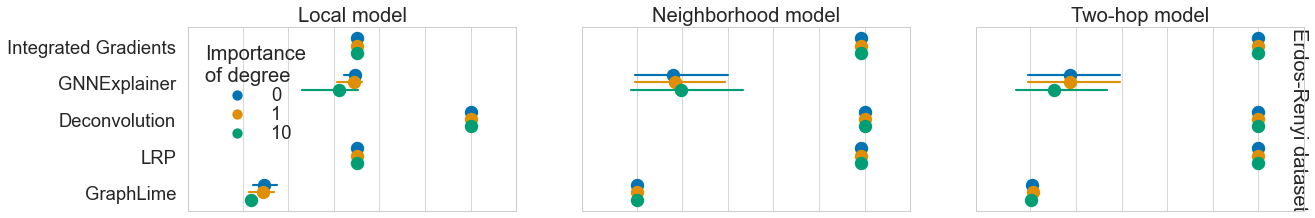

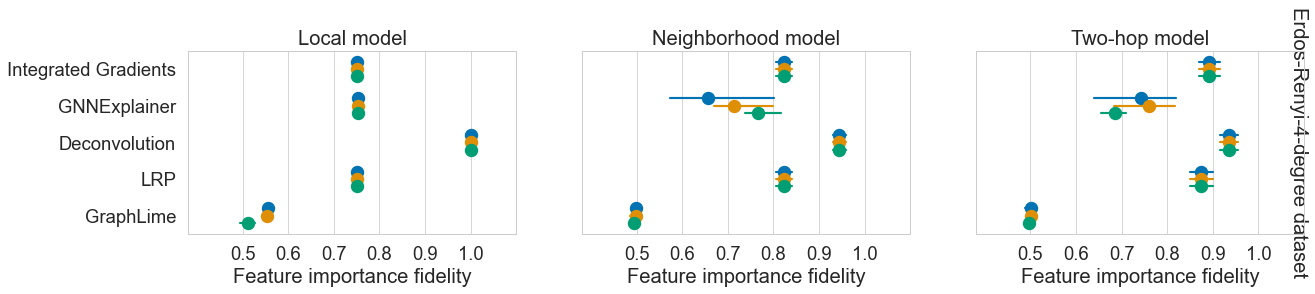

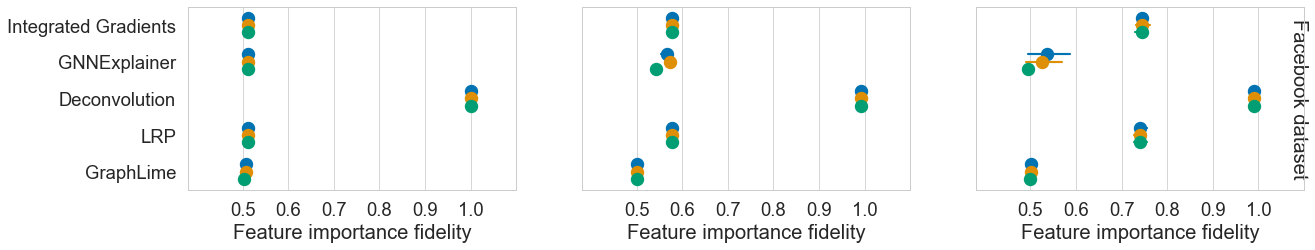

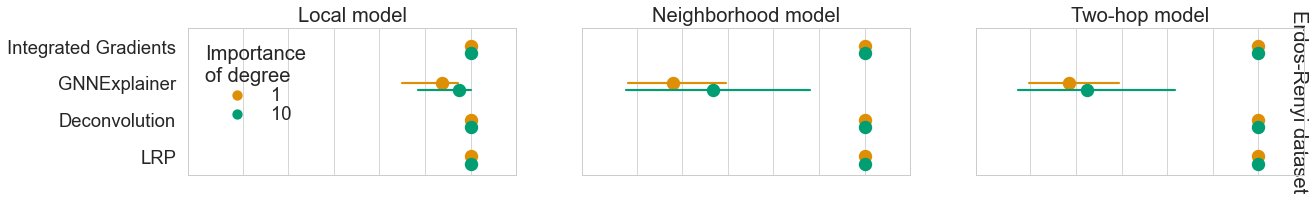

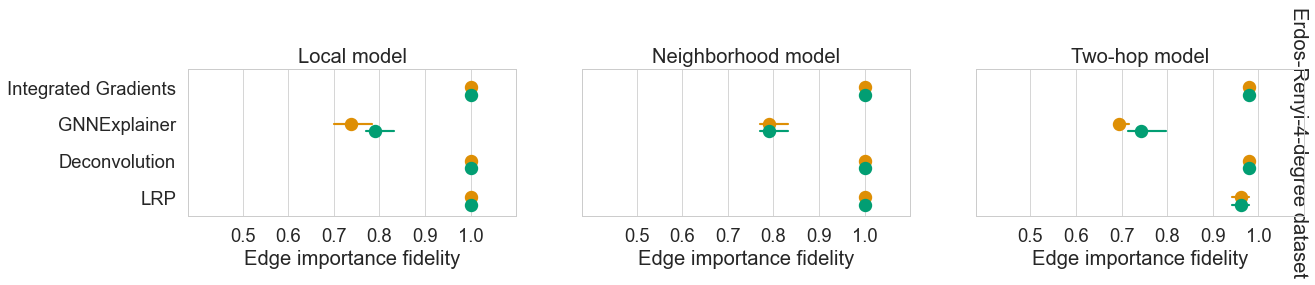

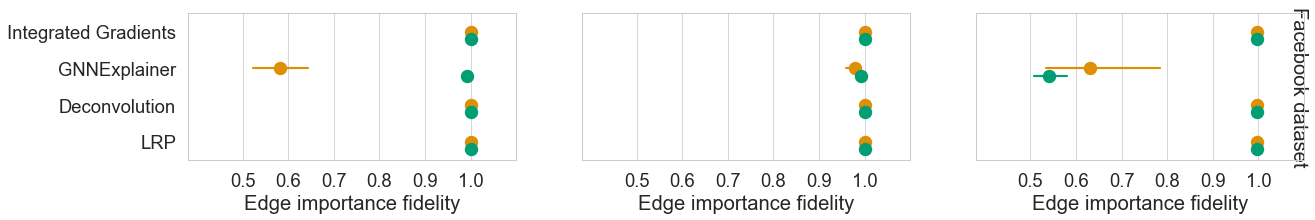

In [9]:
df = df_all[
    (df_all.epochs.isna() | (df_all.epochs == 1000.)) &
    (df_all.gamma < 100) &
    (df_all.frac_important_feat == 0.5) &
    (~df_all.false_as_negatives)
].copy()
df['Importance of degree'] = df.gamma.astype(np.int32)

plt.style.use('seaborn')
sns.set_style("whitegrid")
sns.set_context('paper', font_scale=2.1)

for measure_type in ('Feature', 'Edge'):
    if measure_type == 'Edge':
        plot_explainer_order = [e for e in EXPLAINERS_ORDER if e != 'graphlime']
    else:
        plot_explainer_order = EXPLAINERS_ORDER

    for dataset, dataset_id in DATASETS.items():
        three_plots(df, measure_type, dataset, dataset_id, explainer_order=plot_explainer_order,
                   basepath="../paper/fig/fidelity-with-50-imp-feat-",
                   remove_above=(dataset == "Facebook"),
                   remove_below=(dataset == "Erdos-Renyi"))

# Results with `frac_important_feat=0.1`



 Erdos-Renyi
360 experiments
measure_edges   [True]
gamma           [0.0, 1.0, 10.0]
frac_important_feat [0.1]
noise           [False]
beta_or_delta   ['beta', 'delta']
false_as_negatives [False]
num_nodes       [100.0]
seed            [0, 1, 2, 3, 4, 5, 6, 7]
num_features    [50.0]
mean_degree     [16.0]
explainer       ['deconvolution', 'gnn_explainer', 'graphlime', 'integrated_gradients', 'lrp']
num_samples     [100]
dataset         ['ErdosRenyi-100-nodes-50-features-16-degree']
two_hop         [False, True]
frac_important_edge [0.5]
epochs          [nan, 1000.0]
dataset_id      [nan]
hops            [2.0, nan]
Saved in ../paper/fig/fidelity-with-10-imp-feat-Feature-Erdos-Renyi.pdf


 Erdos-Renyi-4-degree
360 experiments
measure_edges   [True]
gamma           [0.0, 1.0, 10.0]
frac_important_feat [0.1]
noise           [False]
beta_or_delta   ['beta', 'delta']
false_as_negatives [False]
num_nodes       [100.0]
seed            [0, 1, 2, 3, 4, 5, 6, 7]
num_features    [50.0]
mean_degr

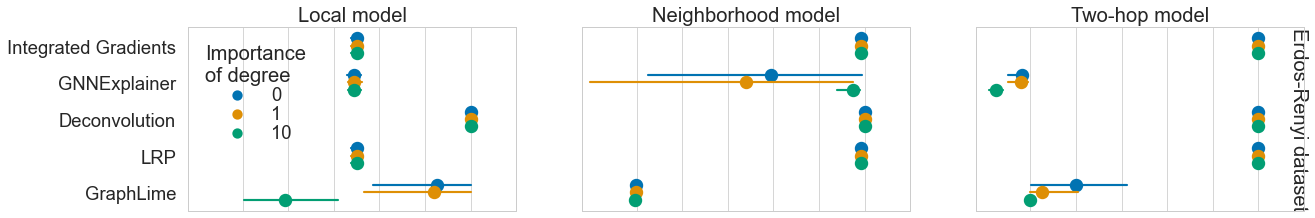

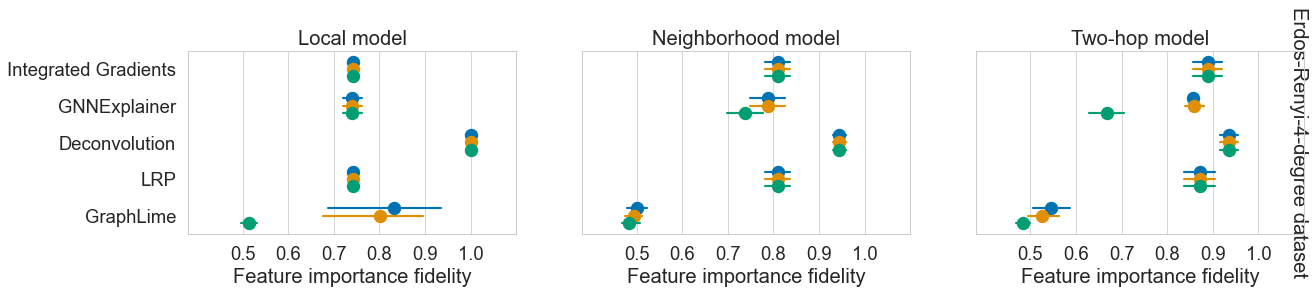

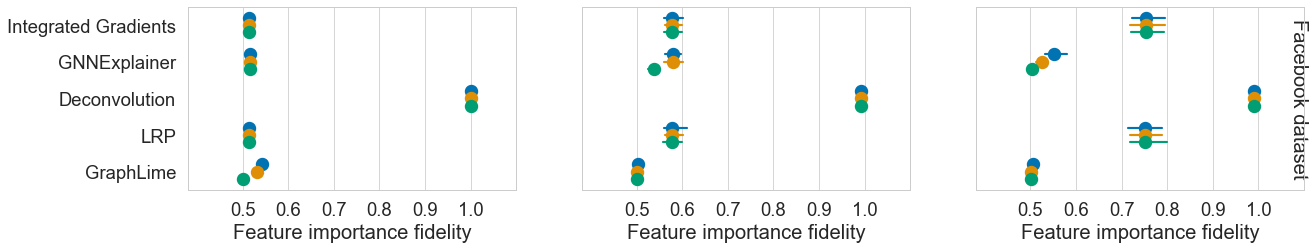

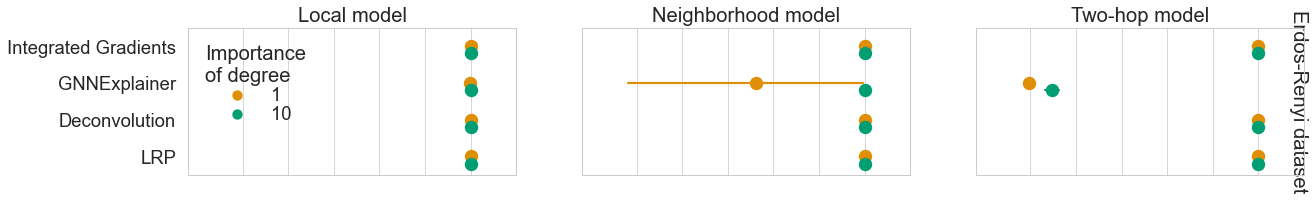

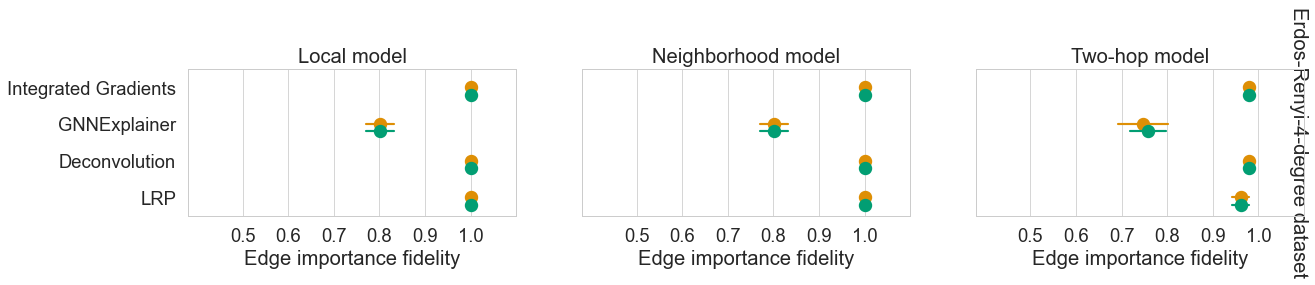

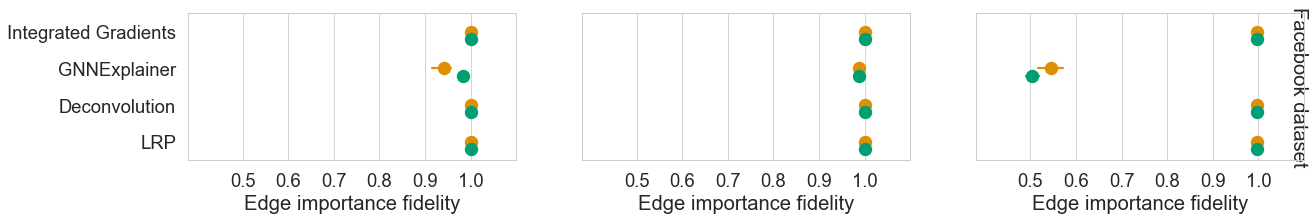

In [10]:
df = df_all[
    (df_all.epochs.isna() | (df_all.epochs == 1000.)) &
    (df_all.gamma < 100) &
    (df_all.frac_important_feat == 0.1) &
    (~df_all.false_as_negatives)
].copy()
df['Importance of degree'] = df.gamma.astype(np.int32)

for measure_type in ('Feature', 'Edge'):
    if measure_type == 'Edge':
        plot_explainer_order = [e for e in EXPLAINERS_ORDER if e != 'graphlime']
    else:
        plot_explainer_order = EXPLAINERS_ORDER

    for dataset, dataset_id in DATASETS.items():
        three_plots(df, measure_type, dataset, dataset_id,
                    explainer_order=plot_explainer_order,
                    basepath="../paper/fig/fidelity-with-10-imp-feat-",
                    remove_above=(dataset == "Facebook"),
                    remove_below=(dataset == "Erdos-Renyi"))

# Results with false encoded as -1 in features



 Erdos-Renyi
360 experiments
measure_edges   [True]
gamma           [0.0, 1.0, 10.0]
frac_important_feat [0.1]
noise           [False]
beta_or_delta   ['beta', 'delta']
false_as_negatives [True]
num_nodes       [100.0]
seed            [0, 1, 2, 3, 4, 5, 6, 7]
num_features    [50.0]
mean_degree     [16.0]
explainer       ['deconvolution', 'gnn_explainer', 'graphlime', 'integrated_gradients', 'lrp']
num_samples     [100]
dataset         ['ErdosRenyi-100-nodes-50-features-16-degree']
two_hop         [False, True]
frac_important_edge [0.5]
epochs          [nan, 1000.0]
dataset_id      [nan]
hops            [2.0, nan]
Saved in ../paper/fig/false-as-negatives-Feature-Erdos-Renyi.pdf


 Facebook
360 experiments
measure_edges   [True]
gamma           [0.0, 1.0, 10.0]
frac_important_feat [0.1]
noise           [False]
beta_or_delta   ['beta', 'delta']
false_as_negatives [True]
num_nodes       [nan]
seed            [0, 1, 2, 3, 4, 5, 6, 7]
num_features    [nan]
mean_degree     [nan]
explainer  

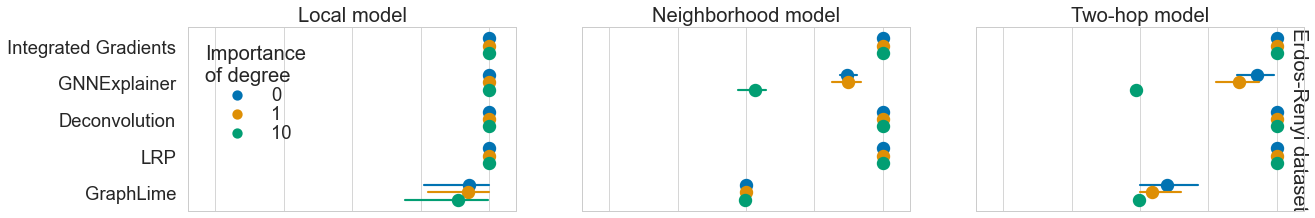

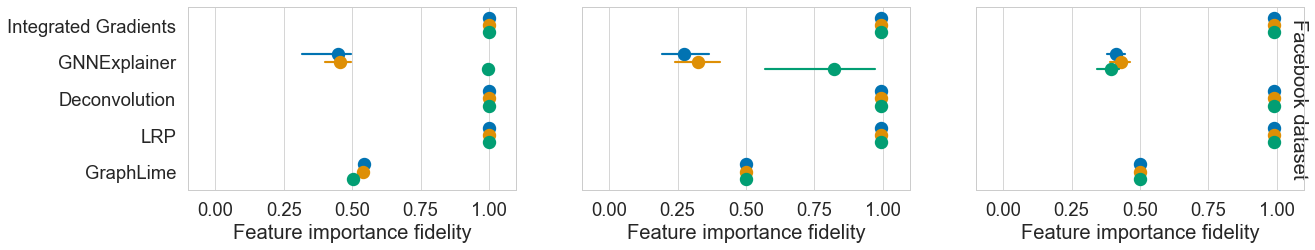

In [11]:

df_false_as_negatives = df_all[
    (df_all.epochs.isna() | (df_all.epochs == 1000.)) &
    (df_all.gamma < 100) &
    (df_all.frac_important_feat == 0.1) &
    (df_all.false_as_negatives)
].copy()
df_false_as_negatives['Importance of degree'] = df_false_as_negatives.gamma.astype(np.int32)

three_plots(df_false_as_negatives, measure_type="Feature",
                dataset='Erdos-Renyi', dataset_id=DATASETS['Erdos-Renyi'],
                remove_below=True, start_from_zero=True,
                model_types=('Local', 'Neighborhood', 'Two-hop'),
                basepath="../paper/fig/false-as-negatives-")

three_plots(df_false_as_negatives, measure_type="Feature",
                dataset='Facebook', dataset_id=DATASETS['Facebook'],
                remove_above=True, start_from_zero=True,
                model_types=('Local', 'Neighborhood', 'Two-hop'),
                basepath="../paper/fig/false-as-negatives-")